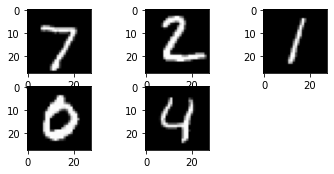

/home/will/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [1]:
import os
import sys
import inspect

sys.path.insert(1, os.path.join(sys.path[0], '..'))

import fatapi
from fatapi.data import Data
from fatapi.model import BlackBox, Model, DensityEstimator, Transformer
import numpy as np
from fatapi.methods import FACEMethod
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt
# load MNIST dataset from local .csv files
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = ""
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",")

train_imgs = np.asfarray(train_data[:, 1:])
train_labels = np.asfarray(train_data[:, :1])
test_imgs = np.asfarray(test_data[:, 1:])
test_labels = np.asfarray(test_data[:, :1])
# load dataset - data to be used by the Model and for counterfactual generation
X_train, y_train, X_test, y_test = train_imgs[:, 100], train_labels, test_imgs, test_labels
row_indicies = [0,1,2,3,4]
for i in row_indicies:
    # define subplot
    img = X_test[i].reshape((image_size,image_size))
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

myencoder = Transformer(transformer=OneHotEncoder())
myscaler = Transformer(transformer=StandardScaler())

# Data object wrapper for dataset and targets of dataset - dtype provides default column indicies for categoricals/numericals
data_X = Data(dataset=X_test, dtype="data")
data_y = Data(dataset=y_test, dtype="target")

# datapoints in X to be used as factuals, wrapped in a Data object
factuals = data_X.get_rows_as_data(row_indicies)
# targets of datapoints in X to be used as factual targets, wrapped in a Data object
# has to return a boolean 
def conditionf(**kwargs):
    return True

# any classifier model with predict, predict_proba, fit and score methods
clf = MLPClassifier(random_state=1, max_iter=300)
# wrapper for any classifier to be used by Methods / Models
blackb = BlackBox(clf)
# Model wrapper - includes blackbox and optional encoder, scaler
face_model = Model(data_X, data_y, blackbox=blackb, encoder=myencoder, scaler=myscaler)
#face_model.train()

print(f"Classes of X_test[:5, :]: {clf.predict(y_test[:5, :])}")
print(f"Predicted classes of X_test[:5, :]: {clf.predict(X_test[:5, :])}")
print(f"Classification accuracy: {clf.score(X_test, y_test)}\n")

print(y_train)

# grid search to find a good KernelDensity estimator (sklearn)
bandwidths = 10 ** np.linspace(-2, 1, 100)  
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=20)
grid.fit(data_X.dataset)
dens_est = grid.best_estimator_

# wrapper for any density estimator ('estimator' has to have fit, score_samples) to be used by FACEMethod
_dens_est = DensityEstimator(
    estimator=dens_est)

# the FACE algorithm with most of the parameters available; required parameters and object specification
# can be seen in the source code
face_method = FACEMethod(factuals=factuals, 
                         factuals_target=factuals_target, 
                         model=face_model, kernel_type="kde", 
                         t_prediction=0.5, epsilon=0.7,
                         t_density=0.0, t_radius_limit=1.10, n_neighbours=20,
                         K=10, conditions=conditionf, density_estimator=_dens_est)
# the main explain() method to generate counterfactuals
print(f"Counterfactuals (return of explain()): {face_method.explain()}\n")
print(f"Graph [Distances - N_samples x N_samples]: \n{face_method.get_graph()}\n")
print(f"Graph = Graph + face_method.get_start_node_edges() if the start node counterfactual is not in X")
print(f"Paths [Indexes]: {face_method.get_explain_paths()}\n")
print(f"Candidates for Counterfactuals [Indexes]: {face_method.get_explain_candidates()}")

counterfactuals_as_indexes = face_method.get_counterfactuals(as_indexes=True)
counterfactuals = face_method.get_counterfactuals()
counterfactuals_data, counterfactuals_target = face_method.get_counterfactuals_as_data()

print(f"Counterfactuals [Indexes]: {face_method.get_counterfactuals(True)}")

print(f"\nfor factual X[{row_indicies[0]}] (as data: {factuals.dataset[0]}), the counterfactual is X[{counterfactuals_as_indexes[0]}] (as classification: {counterfactuals[0]})")
print(f"\nCounterfactual for X[0] (X[6]) as target (Y) and data (X): \nX[{counterfactuals_as_indexes[0]}]: {counterfactuals_data[0]}, Y[{counterfactuals_as_indexes[0]}]: {counterfactuals_target[0]}")